## Background / Motivation

This summer, Evan got in a car crash while driving from the western suburbs to Evanston. It wasn't a very dangerous one, but it was a result of extremely busy road that day as well as some erratic driving near O'Hare. By analyzing these datasets, we aimed to uncover patterns and trends that could provide valuable insights into the factors contributing to crashes, their severity, and the temporal and locational dynamics.

By leveraging data-driven approaches, we aspired to contribute meaningful findings and recommendations that could enhance awareness, guide safety interventions, and ultimately contribute to the improvement of road safety for Evan and all commuters in Chicago.

## Problem statement 

**Crash Severity:**
This category of questions aims to understand the severity of traffic crashes. It explores the percentage of crashes resulting in fatalities versus injuries. Additionally, it delves into specific crash types with the highest fatality rates, the distribution of fatalities among different types of vehicles, and the influence of weather-related factors on crash severity.

**Temporal Influences on Crash Outcomes:**
This category investigates the temporal dynamics of traffic crashes. It analyzes crash frequency based on the time of day, exploring whether specific periods, such as late at night or early morning, are associated with higher crash rates. It also examines crash frequency across different days of the week and evaluates annual crash patterns, considering factors such as increased road usage during specific months and potential correlations with public transportation usage.

**Understanding the Impact of Location on Crashes:**
This category focuses on the spatial aspects of traffic crashes. It seeks to identify areas with the highest crash frequencies and explores potential differences in driver actions or crash types based on the location where the crash occurred. This analysis aims to provide insights into geographical patterns and inform targeted safety interventions.

## Data sources
What data did you use? Provide details about your data. Include links to data if you are using open-access data.

- Traffic Crashes- Crashes: https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
- Traffic Crashes - Vehicles: https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3
- Traffic Crashes - People: https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d
- L Station Ridership Data: https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f

## Stakeholders
Who cares? If you are successful, what difference will it make to them?

**City Transportation Departments:**
- Interest: City transportation departments are concerned with road safety and traffic management. They aim to reduce the number and severity of crashes, ensuring safe and efficient transportation.
- Impact: Successful analysis can inform targeted interventions, traffic management strategies, and infrastructure improvements, contributing to overall road safety.

**Law Enforcement Agencies / Chicago Police:**
- Interest: Law enforcement agencies are responsible for enforcing traffic laws and responding to crashes. They seek insights to improve enforcement strategies and emergency response.
- Impact: Findings can enhance law enforcement's understanding of crash patterns, enabling more effective deployment of resources and proactive safety measures.

**Local Businesses and Residents:**
- Interest: Local businesses and residents are directly affected by traffic conditions and safety. They are interested in living and operating in areas with reduced crash risks.
- Impact: Analysis results can contribute to the development of safer neighborhoods, potentially influencing local economies and quality of life.

## Data quality check / cleaning / preparation 

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did your analysis require any other kind of data preparation before it was ready to use?

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from scipy.stats import pearsonr

In [28]:
traffic_crashes = pd.read_csv("./Datasets/Project_Datasets/Traffic_Crashes_Crashes.csv")
traffic_people = pd.read_csv("./Datasets/Project_Datasets/Traffic_Crashes_People.csv")
traffic_vehicles = pd.read_csv("./Datasets/Project_Datasets/Traffic_Crashes_Vehicles.csv")
cta_data = pd.read_csv("./Datasets/Project_Datasets/CTA_Ridership.csv")

/Users/evanvlahandreas/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (20,24,25,26,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/evanvlahandreas/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Distribution of Data

In [29]:
cta_ordered = cta_data.copy()
cta_ordered['date'] = pd.to_datetime(cta_ordered['date'])
cta_ordered = cta_ordered.sort_values(by='date').reset_index(drop=True)

cta_ordered['month'] = cta_ordered['date'].dt.month
cta_ordered = cta_ordered.loc[cta_ordered['date'].dt.year >= 2018,:].reset_index()

In [30]:
# CLEANING THE TRAFFIC CRASHES DATASET
traffic_crashes_new = traffic_crashes.copy()

traffic_crashes_new = traffic_crashes_new[['CRASH_RECORD_ID', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 'LONGITUDE', 'LOCATION']]

In [31]:
# FILTERING FOR DATA POINTS ONLY IN CHICAGO
traffic_crashes_new = traffic_crashes_new.dropna(subset=['LATITUDE','LONGITUDE','LOCATION'])
traffic_crashes_new = traffic_crashes_new[(traffic_crashes_new['LATITUDE'] > 41.60) & (traffic_crashes_new['LATITUDE'] < 42.10) & 
                                  (traffic_crashes_new['LONGITUDE'] > -88.0) & (traffic_crashes_new['LONGITUDE'] < -87.50)]

In [32]:
# CONVERTING TO DATETIME AND SELECTING DATA STARTING IN 2018
traffic_crashes_new['CRASH_DATE'] = pd.to_datetime(traffic_crashes_new['CRASH_DATE'])
traffic_crashes_new = traffic_crashes_new.loc[traffic_crashes_new['CRASH_DATE'].dt.year >= 2018,:].reset_index()

In [33]:
# CLEANING THE TRAFFIC PEOPLE DATASET
traffic_people = traffic_people.loc[:,['PERSON_ID','PERSON_TYPE','CRASH_RECORD_ID','SEX','AGE','DRIVER_ACTION','DRIVER_VISION']]
traffic_people = traffic_people.loc[traffic_people.PERSON_TYPE == 'DRIVER',:]

In [34]:
# PULLING OUT SIMPLY VEHICLE_TYPE FROM THE TRAFFIC VEHICLES DATASET
traffic_vehicles_type = traffic_vehicles.copy()
traffic_vehicles_type = traffic_vehicles[['CRASH_RECORD_ID', 'VEHICLE_TYPE']]

In [35]:
# MERGING CRASHES AND PEOPLE DATASETS
merged_crashes_people = pd.merge(traffic_crashes_new, traffic_people, on='CRASH_RECORD_ID', how='left')

selected_actions = ['FAILED TO YIELD', 'FOLLOWED TOO CLOSELY', 'IMPROPER BACKING', 'IMPROPER TURN', 'TOO FAST FOR CONDITIONS', 'EVADING POLICE VEHICLE']

merged_crashes_people = merged_crashes_people.loc[merged_crashes_people['DRIVER_ACTION'].isin(selected_actions), :]

In [36]:
# FINALLY MAKING A CLEAN DATASET OF ALL INFORMATION NEEDED FROM ALL THREE ORIGINAL DATASETS
crashes_people_vehicles = pd.merge(merged_crashes_people, traffic_vehicles_type, on='CRASH_RECORD_ID', how='left')

In [37]:
# Continuous variables
continuous_columns = ['AGE', 'CRASH_DATE', 'NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'LATITUDE', 'LONGITUDE', 'POSTED_SPEED_LIMIT']

# Categorical variables
categorical_columns = [
    'CRASH_RECORD_ID',
    'TRAFFIC_CONTROL_DEVICE',
    'DEVICE_CONDITION',
    'WEATHER_CONDITION',
    'LIGHTING_CONDITION',
    'FIRST_CRASH_TYPE',
    'TRAFFICWAY_TYPE',
    'ALIGNMENT',
    'ROADWAY_SURFACE_COND',
    'DAMAGE',
    'PRIM_CONTRIBUTORY_CAUSE',
    'MOST_SEVERE_INJURY',
    'CRASH_HOUR',
    'CRASH_DAY_OF_WEEK',
    'CRASH_MONTH',
    'LOCATION',
    'PERSON_ID',
    'PERSON_TYPE',
    'SEX',
    'DRIVER_ACTION',
    'DRIVER_VISION',
    'VEHICLE_TYPE'
]

In [38]:
print(crashes_people_vehicles[continuous_columns].describe())

                 AGE      NUM_UNITS  INJURIES_TOTAL  INJURIES_FATAL  \
count  349839.000000  500151.000000   500151.000000   500151.000000   
mean       38.672086       2.153100        0.256481        0.001166   
std        16.395285       0.547735        0.664725        0.037259   
min       -47.000000       1.000000        0.000000        0.000000   
25%        26.000000       2.000000        0.000000        0.000000   
50%        35.000000       2.000000        0.000000        0.000000   
75%        50.000000       2.000000        0.000000        0.000000   
max       109.000000      18.000000       21.000000        3.000000   

            LATITUDE      LONGITUDE  POSTED_SPEED_LIMIT  
count  500151.000000  500151.000000       500151.000000  
mean       41.860833     -87.681631           28.796893  
std         0.086411       0.059352            5.585367  
min        41.644670     -87.934014            0.000000  
25%        41.786800     -87.723459           30.000000  
50%        4

In [39]:
# Initialize an empty dataframe to hold the frequency levels
categorical_summary = pd.DataFrame()

for column in categorical_columns:
    # Get the top 3 frequency levels
    top_3_freq = crashes_people_vehicles[column].value_counts(dropna=False).head(3).reset_index()
    top_3_freq.columns = ['Level', 'Frequency']
    
    # Create a summary dataframe for the current variable
    summary_data = pd.DataFrame({
        'Variable': [column],
        'Missing': [crashes_people_vehicles[column].isnull().sum()],
        'Unique': [crashes_people_vehicles[column].nunique()],
        'Most Common Value': [top_3_freq.iloc[0, 0] if len(top_3_freq) > 0 else np.nan],
        'Top1_Freq': [top_3_freq.iloc[0, 1] if len(top_3_freq) > 0 else 0],
        '2nd Most Common Value': [top_3_freq.iloc[1, 0] if len(top_3_freq) > 1 else np.nan],
        'Top2_Freq': [top_3_freq.iloc[1, 1] if len(top_3_freq) > 1 else 0],
        '3rd Most Common Value': [top_3_freq.iloc[2, 0] if len(top_3_freq) > 2 else np.nan],
        'Top3_Freq': [top_3_freq.iloc[2, 1] if len(top_3_freq) > 2 else 0]
    })
    
    # Concatenate the summary of the current variable to the overall summary dataframe
    categorical_summary = pd.concat([categorical_summary, summary_data], axis=0, ignore_index=True)

# Display the final categorical variable summary
categorical_summary

,Variable,Missing,Unique,Most Common Value,Top1_Freq,2nd Most Common Value,Top2_Freq,3rd Most Common Value,Top3_Freq
0,CRASH_RECORD_ID,0,233535,91e621981b63747f5884463564d267a68e1c22b9bf863b...,52,023f7de8d0f7e90dc072b7b88b62502f306469597481da...,48,a736767eac48b46f7ff9eea9f13c0f244a6a10b2d28bc1...,45
1,TRAFFIC_CONTROL_DEVICE,0,19,NO CONTROLS,247649,TRAFFIC SIGNAL,166194,STOP SIGN/FLASHER,68329
2,DEVICE_CONDITION,0,8,NO CONTROLS,254714,FUNCTIONING PROPERLY,215140,UNKNOWN,21516
3,WEATHER_CONDITION,0,12,CLEAR,399727,RAIN,49064,SNOW,18887
4,LIGHTING_CONDITION,0,6,DAYLIGHT,346420,"DARKNESS, LIGHTED ROAD",104021,DARKNESS,19743
5,FIRST_CRASH_TYPE,0,18,REAR END,166065,TURNING,116147,ANGLE,68153
6,TRAFFICWAY_TYPE,0,20,NOT DIVIDED,220667,DIVIDED - W/MEDIAN (NOT RAISED),87049,ONE-WAY,45382
7,ALIGNMENT,0,6,STRAIGHT AND LEVEL,488284,STRAIGHT ON GRADE,6923,"CURVE, LEVEL",2869
8,ROADWAY_SURFACE_COND,0,7,DRY,377301,WET,76138,UNKNOWN,24059
9,DAMAGE,0,3,"OVER $1,500",322616,"$501 - $1,500",124177,$500 OR LESS,53358


## Exploratory Data Analysis

For each analysis:

What did you do exactly? How did you solve the problem? Why did you think it would be successful? 

What problems did you anticipate? What problems did you encounter? Did the very first thing you tried work? 

Mention any code repositories (with citations) or other sources that you used, and specifically what changes you made to them for your project.

Note that you can write code to publish the results of the code, but hide the code using the yaml setting `#|echo: false`. For example, the code below makes a plot, but the code itself is not published with Quarto in the report.

### Pre-Analysis: Demographics

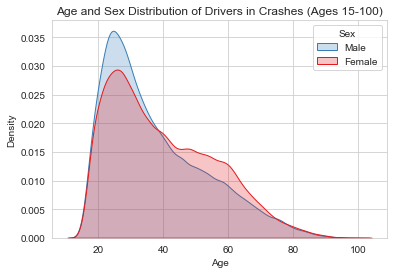

In [40]:
#| echo: false

# Remove rows where 'AGE' or 'SEX' is null
drivers_filtered = crashes_people_vehicles[
    (crashes_people_vehicles['PERSON_TYPE'] == 'DRIVER') &
    (crashes_people_vehicles['AGE'].between(15, 100)) &
    (crashes_people_vehicles['SEX'].isin(['M', 'F']))  # Include only M or F for 'SEX'
].dropna(subset=['AGE', 'SEX'])

# Now you can plot the filtered data
sns.kdeplot(data=drivers_filtered, x='AGE', hue='SEX', common_norm=False, fill=True, palette='Set1')
plt.title('Age and Sex Distribution of Drivers in Crashes (Ages 15-100)')
plt.xlabel('Age')
plt.ylabel('Density')

plt.legend(title='Sex', labels=['Male', 'Female'])

plt.show()

# ANALYSES
All three of us worked though each of the following analyses together

## Analysis 1: Crash Severity

For this analysis, we decided to look at fatality rates and injuries based on different factors such as crash type and whether. The only pproblems we encountered were certain categories having way too few observations, but we ended up grouping similar categories together in order to solve this.

**Which types of crashes exhibit the highest fatality rates (e.g., rear-end collisions, turning accidents)?**

In [41]:
#| echo: false
crash_type_data = crashes_people_vehicles.groupby('FIRST_CRASH_TYPE').agg({'INJURIES_FATAL':'sum', 'CRASH_RECORD_ID':'count'}).rename(columns={'INJURIES_FATAL':'Fatalities', 'CRASH_RECORD_ID':'Total_Crashes'})

In [42]:
#| echo: false
crash_type_data['Fatality_Rate'] = (crash_type_data['Fatalities'] / crash_type_data['Total_Crashes']) * 100
crash_type_data = crash_type_data.sort_values(by="Fatality_Rate", ascending=False)[0:5]
crash_type_data

,Fatalities,Total_Crashes,Fatality_Rate
FIRST_CRASH_TYPE,,,
ANIMAL,2.0,70,2.857143
OVERTURNED,2.0,85,2.352941
PEDESTRIAN,187.0,14935,1.252092
FIXED OBJECT,53.0,5795,0.914582
OTHER NONCOLLISION,1.0,132,0.757576


/var/folders/nm/1vklxxyn675_d144bw7f3lpr0000gn/T/ipykernel_65115/4200173299.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crash_type_data.index, y='Fatality_Rate', data=crash_type_data, palette='viridis')


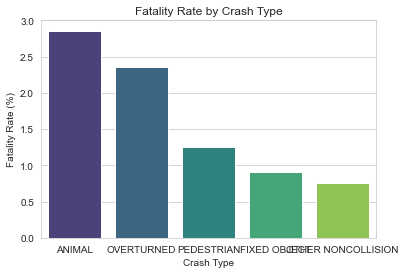

In [43]:
#| echo: false
sns.barplot(x=crash_type_data.index, y='Fatality_Rate', data=crash_type_data, palette='viridis')
plt.ylabel('Fatality Rate (%)')
plt.xlabel('Crash Type')
plt.title('Fatality Rate by Crash Type')
plt.show()

The bar graph above depicts the fatality rate by crash type, highlighting the most lethal types of traffic incidents. Animal-related crashes have the highest fatality rate, followed closely by overturned vehicles, indicating these crash types, while perhaps less frequent, have a higher likelihood of resulting in fatalities. Pedestrian crashes also show a significant fatality rate, which is an important focus area for traffic safety measures. Fixed object and other noncollision types have lower fatality rates but are still non-negligible. This data underscores the critical nature of addressing specific crash types with targeted safety interventions and the importance of understanding crash dynamics to improve road safety outcomes.

**What is the distribution of fatalities among different types of vehicles (passenger, SUV, van, pickup, truck, bus)?**

In [44]:
#| echo: false

vehicles_data = crashes_people_vehicles.copy()

# Remove 'OTHER' and 'UNKNOWN/NA' categories
vehicles_data = vehicles_data[~vehicles_data['VEHICLE_TYPE'].isin(['OTHER', 'UNKNOWN/NA'])]

# Group specified vehicle types
vehicles_data = vehicles_data.replace({
    'PICKUP': 'TRUCK',
    'TRUCK - SINGLE UNIT': 'TRUCK',
    'SINGLE UNIT TRUCK WITH TRAILER': 'TRUCK',
    'MOTORCYCLE (OVER 150CC)': 'MOTORBIKE',
    'MOPED OR MOTORIZED BICYCLE': 'MOTORBIKE',
    '3-WHEELED MOTORCYCLE (2 REAR WHEELS)': 'MOTORBIKE',
    'MOPED OR MOTORIZED BICYCLE': 'MOTORBIKE',
    'MOTOR DRIVEN CYCLE': 'MOTORBIKE',
    'BUS OVER 15 PASS.': 'BUS',
    'BUS UP TO 15 PASS.': 'BUS',
    'TRACTOR W/ SEMI-TRAILER': 'TRACTOR',
    'TRACTOR W/O SEMI-TRAILER': 'TRACTOR'
})

# Assuming 'your_dataset' contains counts for each 'VEHICLE_TYPE'
vehicle_type_counts = vehicles_data['VEHICLE_TYPE'].value_counts()

In [45]:
#| echo: false

vehicles_data['AT_LEAST_ONE_FATALITY'] = vehicles_data['INJURIES_FATAL'] > 0

fatality_rates_by_vehicle = vehicles_data.groupby('VEHICLE_TYPE').agg({
    'CRASH_RECORD_ID': 'count', 
    'AT_LEAST_ONE_FATALITY': 'sum' 
}).rename(columns={'CRASH_RECORD_ID': 'TOTAL_CRASHES', 'AT_LEAST_ONE_FATALITY': 'FATAL_CRASHES'})

# Calculate the fatality rate for each vehicle type
fatality_rates_by_vehicle['FATALITY_RATE'] = (fatality_rates_by_vehicle['FATAL_CRASHES'] / fatality_rates_by_vehicle['TOTAL_CRASHES']) * 100

# Reset index to turn the grouped column back into a regular column
fatality_rates_by_vehicle.reset_index(inplace=True)

In [46]:
#| echo: false

fatality_rates_by_vehicle = fatality_rates_by_vehicle.sort_values(by="FATALITY_RATE", ascending=False)

/var/folders/nm/1vklxxyn675_d144bw7f3lpr0000gn/T/ipykernel_65115/3665787922.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VEHICLE_TYPE', y='FATALITY_RATE', data=fatality_rates_by_vehicle[0:5], palette='viridis')


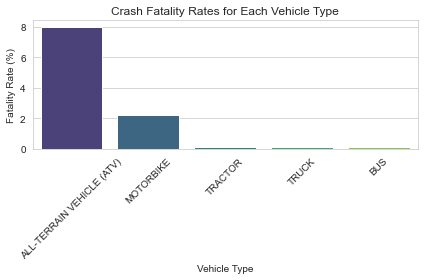

In [47]:
#| echo: false

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the bar plot
sns.barplot(x='VEHICLE_TYPE', y='FATALITY_RATE', data=fatality_rates_by_vehicle[0:5], palette='viridis')

# Add labels and title
plt.xlabel('Vehicle Type')
plt.ylabel('Fatality Rate (%)')
plt.title('Crash Fatality Rates for Each Vehicle Type')
plt.xticks(rotation=45)  

# Show the plot
plt.tight_layout()
plt.show()

The bar graph provides a comparative analysis of crash fatality rates across different vehicle types. It shows that all-terrain vehicles (ATVs) have the highest fatality rate, which is significantly higher than other vehicle types, indicating a potential area of concern for traffic safety and the need for specific preventive measures. Motorbikes also have a notable fatality rate, possibly due to their open and less protected nature. On the other hand, larger vehicles like trucks and buses exhibit much lower fatality rates, which could be attributed to their larger size and mass, possibly offering more protection during crashes. This data emphasizes the importance of vehicle type in the context of traffic safety and the need to tailor safety regulations and measures to the specific risks associated with each vehicle category.

**Are there specific weather-related factors that contribute to variations in crash severity?**

In [48]:
#| echo: false

weather_fatalities = crashes_people_vehicles.groupby('WEATHER_CONDITION').agg({'INJURIES_FATAL': lambda x: (x > 0).sum(), 'CRASH_RECORD_ID': 'count'})
weather_fatalities.rename(columns={'INJURIES_FATAL': 'Fatal_Crashes', 'CRASH_RECORD_ID': 'Total_Crashes'}, inplace=True)

# Calculate Fatality Rate
weather_fatalities['Fatality_Rate'] = (weather_fatalities['Fatal_Crashes'] / weather_fatalities['Total_Crashes']) * 100

In [49]:
#| echo: false
weather_fatalities['Fatality_Rate'].index

Index(['BLOWING SAND, SOIL, DIRT', 'BLOWING SNOW', 'CLEAR', 'CLOUDY/OVERCAST',
       'FOG/SMOKE/HAZE', 'FREEZING RAIN/DRIZZLE', 'OTHER', 'RAIN',
       'SEVERE CROSS WIND GATE', 'SLEET/HAIL', 'SNOW', 'UNKNOWN'],
      dtype='object', name='WEATHER_CONDITION')

In [50]:
#| echo: false

# Remove 'UNKNOWN' and 'OTHER' values
weather_fatalities_cleaned = weather_fatalities[~weather_fatalities.index.isin(['UNKNOWN', 'OTHER'])]

# Combine 'SNOW' and 'BLOWING SNOW' fatalities
weather_fatalities_cleaned.index = weather_fatalities_cleaned.index.map(lambda x: 'SNOW' if x == 'BLOWING SNOW' else x)
weather_fatalities_cleaned = weather_fatalities_cleaned.groupby(level=0).sum()

weather_fatalities_cleaned = weather_fatalities_cleaned.sort_values(by='Fatality_Rate', ascending=False)[0:5]

/var/folders/nm/1vklxxyn675_d144bw7f3lpr0000gn/T/ipykernel_65115/610569640.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weather_fatalities_cleaned.index, y='Fatality_Rate', data=weather_fatalities_cleaned, palette='viridis')


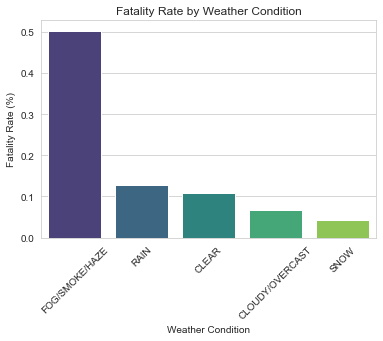

In [51]:
#| echo: false

sns.set_style("whitegrid")

sns.barplot(x=weather_fatalities_cleaned.index, y='Fatality_Rate', data=weather_fatalities_cleaned, palette='viridis')

plt.xlabel('Weather Condition')
plt.ylabel('Fatality Rate (%)')
plt.title('Fatality Rate by Weather Condition')

plt.xticks(rotation=45)
plt.show()

**What are the most frequent driver actions that lead to crashes?**

/var/folders/nm/1vklxxyn675_d144bw7f3lpr0000gn/T/ipykernel_65115/4063475871.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_frequent_driver_actions_crashes.index, y=most_frequent_driver_actions_crashes.values, palette='viridis')


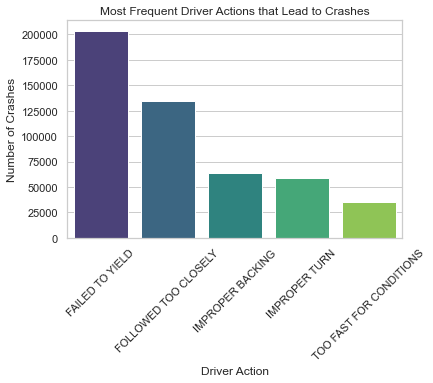

In [92]:
#| echo: false
most_frequent_driver_actions_crashes = crashes_people_vehicles['DRIVER_ACTION'].value_counts().nlargest(5)

# Create the bar plot with seaborn
plt.figure(figsize=(6, 4))
sns.barplot(x=most_frequent_driver_actions_crashes.index, y=most_frequent_driver_actions_crashes.values, palette='viridis')
plt.title('Most Frequent Driver Actions that Lead to Crashes')
plt.ylabel('Number of Crashes')
plt.xlabel('Driver Action')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()

The bar graph represents the relationship between weather conditions and crash fatality rates. It is evident that fog, smoke, or haze conditions lead to the highest fatality rates, likely due to significantly reduced visibility, which may increase the severity of crashes. Rain, while also increasing driving hazards due to slippery roads and potential visibility issues, has a lower fatality rate compared to foggy conditions. Clear and cloudy/overcast weather conditions show relatively lower fatality rates, suggesting that drivers are less likely to experience fatal crashes when adverse weather is not a factor. Snow, which could contribute to dangerous road conditions, surprisingly does not have as high a fatality rate as might be expected, potentially due to more cautious driving behavior during such conditions. This data underscores the critical impact of weather on driving safety and the need for increased caution and potentially more stringent driving regulations in poor visibility conditions.

**How does trafficway type affect the injuries endured during a crash**

/var/folders/nm/1vklxxyn675_d144bw7f3lpr0000gn/T/ipykernel_65115/2345140838.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


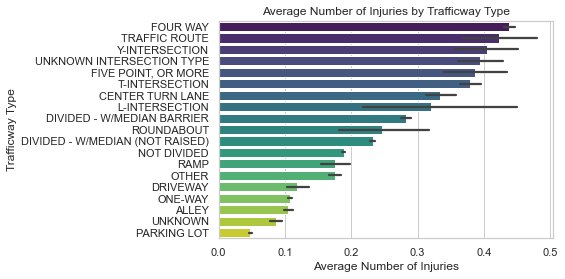

In [52]:
#| echo: false

traffic_crashes_filtered = traffic_crashes_new[traffic_crashes_new['TRAFFICWAY_TYPE'] != 'NOT REPORTED']

# Calculate the average number of injuries for each trafficway type
traffic_crashes_sorted = traffic_crashes_filtered[['INJURIES_TOTAL','TRAFFICWAY_TYPE']].groupby('TRAFFICWAY_TYPE').mean().sort_values(by = 'INJURIES_TOTAL',
                                            ascending= False).index.to_list()

# Plotting using Seaborn
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    x='INJURIES_TOTAL',
    y='TRAFFICWAY_TYPE',
    data=traffic_crashes_filtered,
    palette="viridis",
    order=traffic_crashes_sorted
)

plt.xlabel('Average Number of Injuries')
plt.ylabel('Trafficway Type')
plt.title('Average Number of Injuries by Trafficway Type')
plt.show()

The bar chart indicates the average number of injuries by trafficway type, offering significant insights into the relative safety of different road designs. "Four Way" intersections have the highest average number of injuries, suggesting that these intersections might be more prone to confusing or dangerous conditions leading to accidents. "Traffic Route" and "Y-Intersection" also show higher injury averages, which might be attributed to the increased complexity of navigation and the potential for higher-speed collisions. This information is crucial for urban planners and traffic safety officials, implying a need for improved safety measures at complex intersections, such as clearer signage, enhanced traffic light controls, or redesigning road layouts to reduce conflict points. It also underscores the importance of considering road design when developing strategies to reduce traffic-related injuries.

**How does crash type affect injuries endured during a crash?**

/var/folders/nm/1vklxxyn675_d144bw7f3lpr0000gn/T/ipykernel_65115/719348049.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


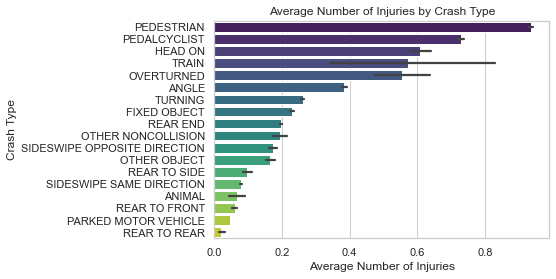

In [93]:
#| echo: false

traffic_crashes_sorted = traffic_crashes_new[['FIRST_CRASH_TYPE','INJURIES_TOTAL']].groupby('FIRST_CRASH_TYPE').mean().sort_values(by = 'INJURIES_TOTAL',
                                            ascending= False).index.to_list()
# Plotting using Seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    x='INJURIES_TOTAL',
    y='FIRST_CRASH_TYPE',
    data=traffic_crashes_new,
    palette="viridis",
    order=traffic_crashes_sorted
)

plt.xlabel('Average Number of Injuries')
plt.ylabel('Crash Type')
plt.title('Average Number of Injuries by Crash Type')
plt.show()

The bar graph presents the average number of injuries by crash type, highlighting the severity of incidents involving pedestrians and pedal cyclists as they have the highest average number of injuries. Head-on and train-related crashes also show a higher impact, which might be due to the higher speeds or forces involved. The data indicates that crashes with vulnerable road users or at high speeds are more likely to result in injuries. This underscores the importance of safety measures for non-vehicle traffic and the enforcement of speed limits to prevent severe injuries.

## Analysis 2: Temporal Influences

For this analysis, we analyzed when most crashes occur, hypothesizing a spike during rush hour and in winter months. We initially wanted to look at special holidays as well but found it difficult to compare dates because the exact time of special holidays changed each year. 

### Time of Day

**How does crash frequency vary based on the time of day? Are there particular time periods, such as late at night or early morning, associated with higher rates of crashes?**

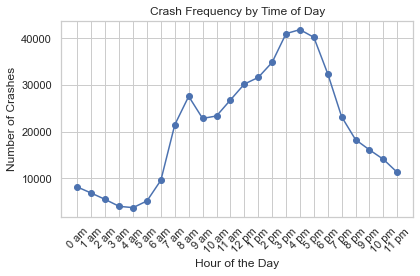

In [54]:
#| echo: false

# Convert 'CRASH_DATE' to datetime and extract the hour
crashes_people_vehicles['CRASH_HOUR'] = pd.to_datetime(crashes_people_vehicles['CRASH_DATE']).dt.hour

# Counting crashes by hour and reindex to make sure all hours are represented
crash_counts = crashes_people_vehicles['CRASH_HOUR'].value_counts().reindex(range(24)).fillna(0).sort_index()

# Create labels for the x-ticks to include every hour of the day
hour_labels = [f"{i} am" if i < 12 else ("12 pm" if i == 12 else f"{i-12} pm") for i in range(24)]

# Line Chart of Crash Frequency by Hour
plt.plot(crash_counts.index, crash_counts.values, marker='o', linestyle='-', color='b')
plt.title('Crash Frequency by Time of Day')
plt.xticks(range(0, 24), hour_labels, rotation=45) 
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crashes')
plt.grid(True)  
plt.tight_layout() 
plt.show()

The line graph depicts the frequency of traffic crashes throughout different hours of the day. There's a notable increase in crashes starting from the early morning, peaking during the late afternoon hours, which could correlate with rush hour when traffic density increases significantly. The evening sees a gradual decline in crashes, with the lowest frequency occurring late at night and into the early morning hours, possibly due to fewer vehicles on the road. This pattern suggests that the risk of crashes is higher during the daytime, especially in the afternoon, which could be due to various factors such as increased traffic volume, driver fatigue post-lunch, and the potential for more distractions. Moreover, the lower incidence of crashes at night might be influenced by less traffic, although this might also be the time when factors like fatigue and poor visibility increase the risk of more severe crashes.

### Day of the Week

**What is the distribution of crash frequency across different days of the week? Are weekends associated with more crashes compared to weekdays?**

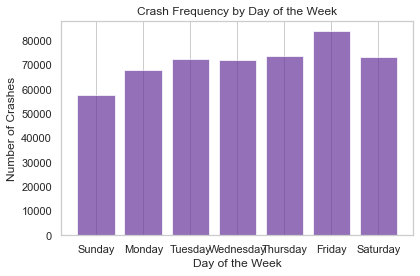

In [94]:
#| echo: false

day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Counting crashes by day of the week and reindex to make sure all days are represented
crash_counts = crashes_people_vehicles['CRASH_DAY_OF_WEEK'].value_counts().reindex(range(1, 8), fill_value=0).sort_index()

# Bar Chart of Crash Frequency by Day of the Week
plt.figure(figsize=(6, 4))
plt.bar(crash_counts.index, crash_counts.values, color='rebeccapurple', alpha=0.7)
plt.title('Crash Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crashes')
plt.xticks(crash_counts.index, day_names)  # Replace numerical x-ticks with day names
plt.grid(axis='y')  # Adds horizontal gridlines for better readability
plt.tight_layout()  # Fits the plot within the figure area
plt.show()

The bar chart presents the crash frequency by day of the week, displaying a consistent pattern with no extreme variations. The data suggests that the number of crashes remains relatively stable across weekdays and weekends, contradicting common assumptions that weekends might see a significant increase in crash frequency. Interestingly, the slight differences observed do not indicate a clear trend towards more crashes on either weekdays or weekends. This uniform distribution prompts further investigation into other factors that could influence daily crash rates, such as commuter patterns, leisure activities, and traffic enforcement practices that are constant throughout the week. This analysis could be enriched by examining the severity and types of crashes occurring on each day to determine if any particular day is more prone to serious incidents.

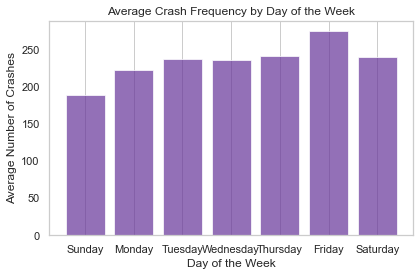

In [95]:
#| echo: false

num_weeks = (crashes_people_vehicles['CRASH_DATE'].max() - crashes_people_vehicles['CRASH_DATE'].min()).days / 7

# Counting crashes by day of the week
crash_counts = crashes_people_vehicles['CRASH_DAY_OF_WEEK'].value_counts().reindex(range(1, 8), fill_value=0).sort_index()

# Calculate average crashes per day of the week
average_crashes = crash_counts / num_weeks

# Bar Chart of Average Crash Frequency by Day of the Week
plt.figure(figsize=(6, 4))
plt.bar(average_crashes.index, average_crashes.values, color='rebeccapurple', alpha=0.7)
plt.title('Average Crash Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Crashes')
plt.xticks(average_crashes.index, day_names)  # Replace numerical x-ticks with day names
plt.grid(axis='y')  # Adds horizontal gridlines for better readability
plt.tight_layout()  # Fits the plot within the figure area
plt.show()

The bar chart depicting average crash frequency by day of the week reveals a relatively even distribution of traffic crashes across all days, with slight variations. It's notable that there isn't a significant spike on weekends, which might be anticipated given the potential increase in recreational travel and alcohol consumption. Instead, the data suggests that the risk of crashes is consistent regardless of the day, implying that daily routines such as commuting, school runs, and regular local errands contribute substantially to traffic crash statistics. This information could be pivotal for traffic management and enforcement strategies, as it indicates the necessity for consistent safety measures throughout the week rather than a focus on weekend or weekday patterns.

### Annual Crash Patterns

**If there is a month when a disproportionate amount of crashes occur, can this be explained by an increase in people on the road? Can we explain this by looking at the number of CTA rides within that month (more CTA rides may indicate fewer cars on the road)**

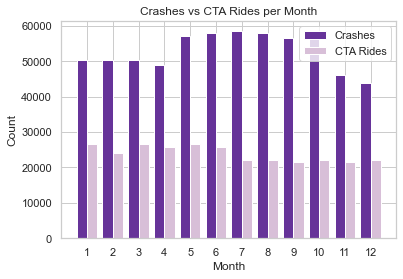

In [57]:
#| echo: false

crashes_per_month = traffic_crashes_new['CRASH_MONTH'].value_counts().sort_index()
crashes_per_month

cta_rides_per_month = cta_ordered['month'].value_counts().sort_index()
cta_rides_per_month

# Bar plot for crashes
plt.bar(crashes_per_month.index - 0.2, crashes_per_month.values, width=0.4, label='Crashes', color='rebeccapurple')

# Bar plot for CTA rides
plt.bar(cta_rides_per_month.index + 0.2, cta_rides_per_month.values, width=0.4, label='CTA Rides', color='thistle')

# Add labels and legend
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Crashes vs CTA Rides per Month')
plt.xticks(np.arange(1, 13))  # Assuming months are from 1 to 12
plt.legend()

# Show the plot
plt.show()

In [58]:
#| echo: false

# Calculate correlation coefficient
correlation_coefficient, p_value = pearsonr(crashes_per_month, cta_rides_per_month)

# Print correlation coefficient and p-value
print(f"Correlation Coefficient: {correlation_coefficient:.2f}")
print(f"P-value: {p_value:.4f}")

# Check for significance (common alpha level is 0.05)
alpha = 0.05
if p_value < alpha:
    print("The correlation is statistically significant.")
else:
    print("The correlation is NOT statistically significant.")

Correlation Coefficient: -0.04
P-value: 0.9008
The correlation is NOT statistically significant.


The bar chart compares traffic crashes and CTA rides per month, offering insights into the relationship between public transportation usage and the occurrence of crashes. The observed correlation coefficient of -0.04, coupled with a non-significant p-value (0.9008), suggests that there is no significant linear relationship between these two variables.

Despite the lack of statistical significance, a visual examination of the chart reveals a potential pattern: higher crash counts tend to coincide with months of lower CTA rides. This observation raises the possibility that reduced public transportation use might be associated with an increase in the number of vehicles on the road, potentially leading to more crashes.

This trend is particularly noticeable in warmer months, where an uptick in recreational travel may contribute to both increased crash counts and decreased public transit usage. The data implies that promoting public transit usage could be a strategy to reduce traffic congestion and potentially lower the risk of accidents. However, it's essential to note that further in-depth analysis is required to fully understand the complex interplay of factors influencing these trends.

**How has crash frequency changed over the past 5 years?**

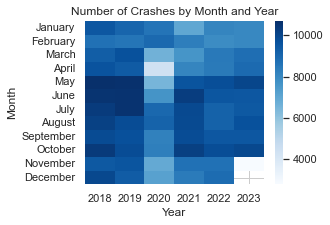

In [97]:
#| echo: false

# Ensure the 'CRASH_DATE' is a datetime type
traffic_crashes_new['CRASH_DATE'] = pd.to_datetime(traffic_crashes_new['CRASH_DATE'])

# Extract year and month from 'CRASH_DATE'
traffic_crashes_new['year'] = traffic_crashes_new['CRASH_DATE'].dt.year
traffic_crashes_new['month'] = traffic_crashes_new['CRASH_DATE'].dt.month_name()

# Pivot the data to get a matrix of year vs month
heatmap_data = traffic_crashes_new.groupby(['year', 'month']).size().unstack(level=0)

# Sort the months in calendar order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data.reindex(months_order)

# Create the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(heatmap_data, cmap="Blues")
plt.title('Number of Crashes by Month and Year')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()

The heatmap provides a visual representation of the number of crashes by month over a five-year period. A distinct pattern emerges, showing variability in crash frequency throughout the year, with certain months consistently experiencing higher numbers of crashes. The data suggests a seasonal trend, with peaks often occurring in the milder months, which might be attributed to increased travel and road activity during these times. Additionally, there appears to be a significant drop in crashes in 2020, which could be correlated with the global COVID-19 pandemic and the subsequent restrictions on movement, leading to less traffic. This trend seems to reverse in the following years as restrictions are lifted, highlighting the impact of external factors on road safety and crash frequency.

## Analysis 3: Locations

For this analysis, we looked at where most crashes occur. We found it a little bit difficult to see major changes in density, so we had to play with the palette to make it more severe. Additionally, we found it a bit difficult to quantify the effects of location on crashes. 

**Overall, where do most crashes occur?**

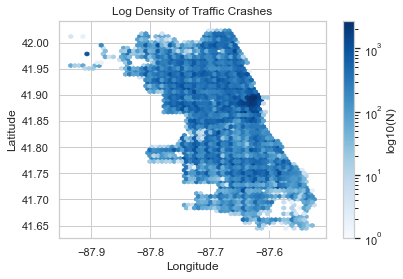

In [98]:
#| echo: false
plt.figure(figsize=(6, 4))
plt.hexbin(crashes_people_vehicles['LONGITUDE'], crashes_people_vehicles['LATITUDE'], gridsize=60, cmap='Blues', 
           bins='log')
plt.colorbar(label='log10(N)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Log Density of Traffic Crashes')
plt.show()

This hexbin map displays the log density of traffic crashes in a specific region, with darker shades indicating higher frequencies of incidents. The highest concentration of crashes is notably in the central areas, which may correlate with higher population density, increased traffic flow, and possibly more complex road networks. This visualization supports targeted interventions in high-density crash zones, such as enhanced traffic enforcement and improved road safety measures. It also underscores the importance of urban planning and the potential benefits of promoting public transportation to reduce the number of vehicles on the road, which could decrease the overall crash rates in these hotspots.

**Are there differences in driver actions or type of crash depending on the location where the crash occurred?**

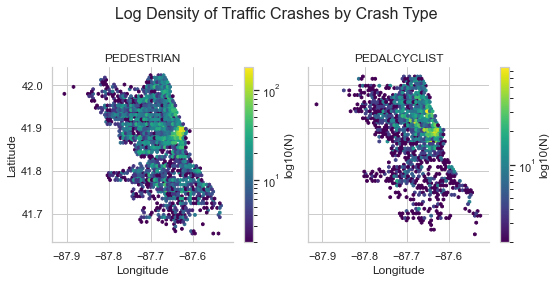

In [99]:
#| echo: false

crashes_subset = ['PEDESTRIAN','PEDALCYCLIST']

# Filter the data to include only the pedestrians and cyclists
pedests_and_bikers = crashes_people_vehicles[crashes_people_vehicles['FIRST_CRASH_TYPE'].isin(crashes_subset)]

# Define a function to create hexbin plots
def hexbin(x, y, color, **kwargs):
    plt.hexbin(x, y, gridsize=60, cmap='viridis', bins='log', **kwargs)
    plt.colorbar(label='log10(N)')

# Create a FacetGrid with the top 5 crash types
g = sns.FacetGrid(pedests_and_bikers, col='FIRST_CRASH_TYPE', sharex=True, sharey=True, height=4)

# Map the hexbin function to each subplot
g.map(hexbin, 'LONGITUDE', 'LATITUDE')

# Set axis labels
g.set_axis_labels('Longitude', 'Latitude')

# Set titles for each subplot
g.set_titles(col_template="{col_name}")

g.fig.suptitle('Log Density of Traffic Crashes by Crash Type', fontsize=16)

# Adjust the layout so that titles and labels don't overlap
g.fig.tight_layout(w_pad=1, rect=[0, 0, 1, 0.96])  # Adjust the top parameter to make space for the main title

# Show the plot
plt.show()

The hexbin maps provide a visual representation of traffic crashes categorized by whether pedestrians or cyclists were involved in the crash. Unsurprisingly, the majority of crashes for both types occur in downtown Chicago, near the Loop and River North, but two other trends are apparent: for pedestrians, crashes along lakefront trail going north are slighly more prevalent, and for cyclists, a similar trend appears coupled with another high density along I-90 / Clybourn Avenue. Factors contributing to this trend could include the presence of dedicated bike lanes, the popularity of cycling routes in the area, or specific intersections that pose challenges for cyclists.
Additionally, the proximity to I-90 may introduce complexities related to interactions between cyclists and faster-moving vehicular traffic.

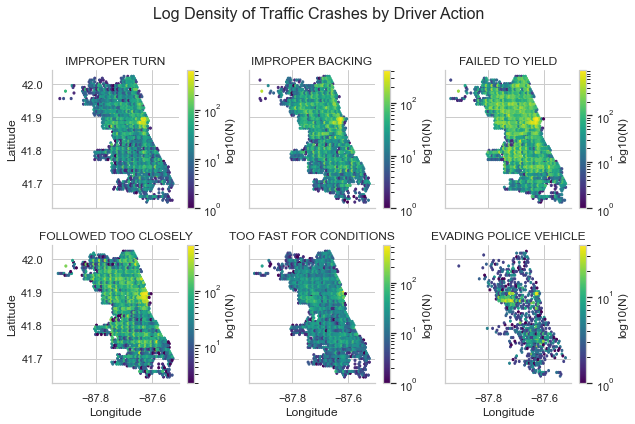

In [100]:
#| echo: false

# Define a function to create hexbin plots
def hexbin(x, y, color, **kwargs):
    plt.hexbin(x, y, gridsize=60, cmap='viridis', bins='log', **kwargs)
    plt.colorbar(label='log10(N)')

# Create a FacetGrid with the top 5 crash types
g = sns.FacetGrid(crashes_people_vehicles, col='DRIVER_ACTION', col_wrap=3, sharex=True, sharey=True, height=3)

# Map the hexbin function to each subplot
g.map(hexbin, 'LONGITUDE', 'LATITUDE')

# Set axis labels
g.set_axis_labels('Longitude', 'Latitude')

# Set titles for each subplot
g.set_titles(col_template="{col_name}")

g.fig.suptitle('Log Density of Traffic Crashes by Driver Action', fontsize=16)

# Adjust the layout so that titles and labels don't overlap
g.fig.tight_layout(w_pad=1, rect=[0, 0, 1, 0.96]) 

# Show the plot
plt.show()

The hexbin maps provide a visual representation of traffic crashes categorized by different driver actions across a geographical area. The density of crashes related to 'Improper Turn', 'Improper Backing', and 'Failed to Yield', among others, are concentrated in specific regions, possibly indicative of complex intersections or high-density traffic zones where such maneuvers are more challenging. 'Evading Police Vehicle' incidents, while less frequent, show a distinct pattern, potentially pinpointing areas with higher incidences of pursuits or enforcement-related activities. On these graphs, those areas seem to be located around close to I-290 in the North Lawndale, Garfield Park, and Humboldt Park neighborhoods. These insights can guide traffic safety measures, such as reinforcing the need for clearer signage, enhanced enforcement, and driver education campaigns tailored to mitigate the risks associated with these specific driver actions. Connecting to previous analyses, it becomes clear that driver behavior, coupled with environmental factors, significantly influences the likelihood and distribution of traffic accidents.

## Future Directions

**In-Depth Driver Behavior Analysis:**
Future research could delve deeper into understanding driver behavior leading to crashes. Analyzing factors like driver distraction, impairment, and aggressive driving patterns could provide a more nuanced understanding of the causes behind crashes.

**Long-Term Impact Analysis of Safety Interventions:**
Evaluating the long-term effectiveness of safety interventions and infrastructure improvements would be valuable. Research could focus on assessing the sustained impact of measures implemented to enhance road safety.

**Community Engagement and Education Programs:**
Research could focus on the effectiveness of community engagement and education programs in promoting road safety. Understanding how targeted awareness campaigns influence driver behavior and attitudes is crucial for designing impactful interventions.

**A Comprehensive Look at the Impact of Special Events on Crash Data:**
During special events like Lollapalooza, the Chicago Marathon, The Air and Water Show, and, this past year, Taylor Swift's Eras Tour, traffic patterns change drastically in Chicago. It would thus be interesting to look at where Chicago Police and Transit authorities should be adding resources on these dates and what those safety measures should be.

## Conclusions

Do the individual analysis connect with each other to answer a bigger question? If yes, explain.

Yes, all of our analyses connect to the following question: how do we increase drivers' safety on the road?

For instance...
- The identification of peak traffic areas and patterns in the analysis supports the recommendation for public transportation campaigns. By encouraging public transit use in high-traffic zones, the goal is to reduce congestion, potentially lowering the risk of accidents.
- The analysis of driver actions and crash types by location informs law enforcement's resource deployment strategy. By targeting areas with specific crash patterns, law enforcement can focus on addressing the root causes of accidents and improving overall safety.
- The analysis of crash patterns assists Emergency Medical Services (EMS) in strategically allocating resources, including where to place emergency medical services or even open a new hospital/medical center. Collaborative preparedness with law enforcement ensures a coordinated response in high-risk areas, enhancing overall emergency response effectiveness.

## Recommendations to stakeholder(s)
What are the action items for the stakeholder(s) based on your analysis? Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

Do the stakeholder(s) need to be aware about some limitations of your analysis? Can your analysis be directly used by the stakeholder(s) to obtain the expected benefit / make decisions, or do they need to do some further analysis based on their own, or do they need to repeat your analysis on a more recent data for the results to be applicable? 

### Recommendation #1: 
**Increase CTA ridership at peak hours and days (3-5pm every day, especially Friday)**

Advertise reduced commute times, cost savings, and environmental impact. Explore discounted fare programs, improved transit routes, and increased frequency of services.

**IMPACT:** This may reduce crashes by up to 51917 crashes.

In [74]:
# Count the number of crashes for each day of the week.
day_counts = crashes_people_vehicles['CRASH_DAY_OF_WEEK'].value_counts()

# Assuming Friday is represented as '5'.
friday_crashes = day_counts[5]

# Calculate the total number of crashes.
total_crashes = day_counts.sum()

# Calculate the percentage of crashes that occur on Friday.
friday_percentage = (friday_crashes / total_crashes) * 100

even_spread = 100/7

print(friday_percentage)
print(even_spread)

14.678767012362268
14.285714285714286


In [75]:
# Convert 'CRASH_DATE' to datetime and extract the hour
crashes_people_vehicles['CRASH_HOUR'] = pd.to_datetime(crashes_people_vehicles['CRASH_DATE']).dt.hour

# Counting crashes by hour and reindex to make sure all hours are represented
crash_counts = crashes_people_vehicles['CRASH_HOUR'].value_counts().reindex(range(24)).fillna(0).sort_index()

In [80]:
crash_count_3hr_period = crash_counts.mean() * 3
crash_count_3hr_period

62518.875

In [89]:
rush_hour = crash_counts[16:19]
rush_hour_3hr_period = rush_hour.mean() * 3
rush_hour_3hr_period

114436.0

In [90]:
rush_hour_3hr_period - crash_count_3hr_period

51917.125

### Recommendation #2: 
**Increase natural slowing mechanisms in downtown area**

This may include narrower lanes, speed humps, textured road surfaces, and other traffic calming measures.

**IMPACT:** This would reduce crashes by up to 47.84115197210442%.

We chose these three categories because they were in the top 5 crashes by driver action and could be mitigated by creating greater distance between cars.

In [72]:
# Assuming crashes_people_vehicles is your dataframe and DRIVER_ACTION is the column of interest
driver_actions_counts = crashes_people_vehicles['DRIVER_ACTION'].value_counts()

# Get the counts for each action
failed_to_yield_count = driver_actions_counts.get('FAILED TO YIELD', 0)
following_too_closely_count = driver_actions_counts.get('FOLLOWING TOO CLOSELY', 0)
too_fast_for_conditions_count = driver_actions_counts.get('TOO FAST FOR CONDITIONS', 0)

# Calculate the total number of crashes
total_crashes = driver_actions_counts.sum()

# Calculate the percentages
failed_to_yield_pct = (failed_to_yield_count / total_crashes) * 100
following_too_closely_pct = (following_too_closely_count / total_crashes) * 100
too_fast_for_conditions_pct = (too_fast_for_conditions_count / total_crashes) * 100

# Calculate the combined percentage
combined_pct = (failed_to_yield_count + following_too_closely_count + too_fast_for_conditions_count) / total_crashes * 100

failed_to_yield_pct, following_too_closely_pct, too_fast_for_conditions_pct, combined_pct

(40.74169600780564, 0.0, 7.099455964298781, 47.84115197210442)

### Recommendation #3: 
As crashes involving pedestrians and cyclists have high fatality rates, we must **develop and maintain dedicated lanes and paths for cyclists and pedestrians, physically separated from vehicular traffic with a barrier where possible.** For both, these paths should be expanded in downtown Chicago, near the Loop and River North as this is where our data showed the highest density of pedestrian and cyclist crashes. But for cyclists, an improved bike path along I-90 / Clybourn Avenue may have high demand, as shown by the denser cyclist crashes along this route. This could look similar to the Highline in New York.

**IMPACT:** This would reduce crashes by up to 4.26%.

In [67]:
# Count of crashes involving cyclists
cyclist_crashes = crashes_people_vehicles[crashes_people_vehicles['FIRST_CRASH_TYPE'] == 'PEDALCYCLIST'].shape[0]

# Count of crashes involving pedestrians
pedestrian_crashes = crashes_people_vehicles[crashes_people_vehicles['FIRST_CRASH_TYPE'] == 'PEDESTRIAN'].shape[0]

# Total number of crashes
total_crashes = crashes_people_vehicles.shape[0]

# Proportion of crashes involving cyclists and pedestrians
proportion_cyclist = cyclist_crashes / total_crashes
proportion_pedestrian = pedestrian_crashes / total_crashes
total_prop = proportion_pedestrian + proportion_cyclist

print(f"Proportion of Crashes involving Cyclists: {proportion_cyclist:.2%}")
print(f"Proportion of Crashes involving Pedestrians: {proportion_pedestrian:.2%}")
print(f"Total: {total_prop:.2%}")

Proportion of Crashes involving Cyclists: 1.28%
Proportion of Crashes involving Pedestrians: 2.99%
Total: 4.26%
